In [1]:
# 自定义数据集（dataset）
# 1.构造torch自定义的dataset
# 2.数据增强
# 3.测试一下dataloader加载
# 4.测试显示一些图片

In [2]:
# 导入相关包
import torch
import numpy as np
import matplotlib.pyplot as plt
import glob

D:\Anaconda\envs\unet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 构造自定义的dataset

In [4]:
from torch.utils.data import Dataset,DataLoader

In [5]:
class SegmentDataset(Dataset):
    def __init__(self,where='train'):
        # 获取numpy文件数据
        # 图片列表
        self.img_list = glob.glob('processed/{}/*/img_*'.format(where))
        # self.mask_list = glob.glob('processed/{}/*/label_*'.format(where))
    
    def __len__(self):
        # 获取数据集大小
        return len(self.img_list)
    
    def __getitem__(self,idx):
        # 获取具体某一个数据
        
        # 获取图片文件名
        img_file = self.img_list[idx]
        # 获取标注文件名
        mask_file = img_file.replace('img','label')
        
        # 加载数据
        img = np.load(img_file)
        mask = np.load(mask_file)
        
        # 扩张维度变成张量
        return np.expand_dims(img,0),np.expand_dims(mask,0)

In [23]:
# 加载训练集所有图片
dataset = SegmentDataset('train')

In [24]:
len(dataset)

1932

In [25]:
# 显示一些16张图

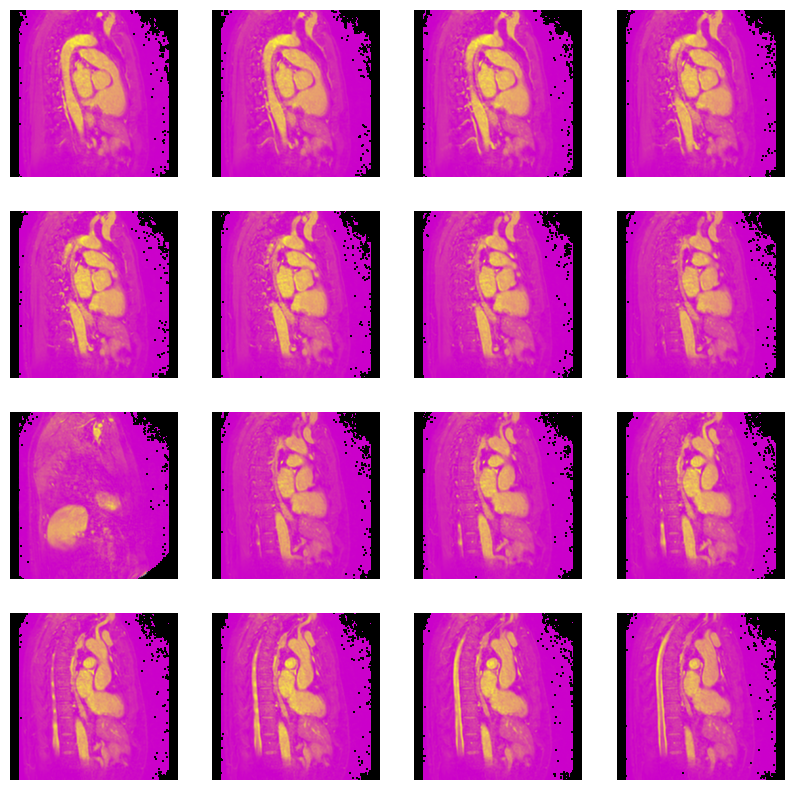

In [26]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    
    # 获取数据
    img,mask = dataset[i+100]
    
    
    # 将mask和图片绘制在一起
    img_display = np.rot90(img[0])
    mask_display = np.rot90(mask[0])   
    # 将mask_display像素值为0处遮挡起来
    mask = np.ma.masked_where(mask_display==0,mask_display)
    plt.imshow(img_display,cmap='bone')
    plt.imshow(mask,alpha=0.8,cmap='spring')
    
    plt.axis('off')
    
plt.show()

In [27]:
# 导入imgaug数据增强工具包

In [28]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [29]:
class SegmentDataset(Dataset):
    def __init__(self,where='train',seq=None):
        # 获取numpy文件数据
        # 图片列表
        self.img_list = glob.glob('processed/{}/*/img_*'.format(where))
        # self.mask_list = glob.glob('processed/{}/*/label_*'.format(where))
        # 数据增强的处理流程
        self.seq = seq
        
    def __len__(self):
        # 获取数据集大小
        return len(self.img_list)
    
    def __getitem__(self,idx):
        # 获取具体某一个数据
        
        # 获取图片文件名
        img_file = self.img_list[idx]
        # 获取标注文件名
        mask_file = img_file.replace('img','label')
        
        # 加载数据
        img = np.load(img_file)
        mask = np.load(mask_file)
        
        # 数据增强处理
        if self.seq:
            segmap = SegmentationMapsOnImage(mask,shape=mask.shape)
            img,mask = self.seq(image=img, segmentation_maps=segmap)
            # 获取数组内容
            mask = mask.get_arr()

            
        # 扩张维度变成张量
        return np.expand_dims(img,0),np.expand_dims(mask,0)

In [30]:
# 数据增强的处理流程
seq = iaa.Sequential([
    iaa.Affine(
        scale=(0.8,1.2), # 缩放
        rotate=(-45,45) # 旋转
    ),
    iaa.ElasticTransformation() # 弹性形变
])

In [31]:
dataset = SegmentDataset('train',seq)

In [32]:
len(dataset)

1932

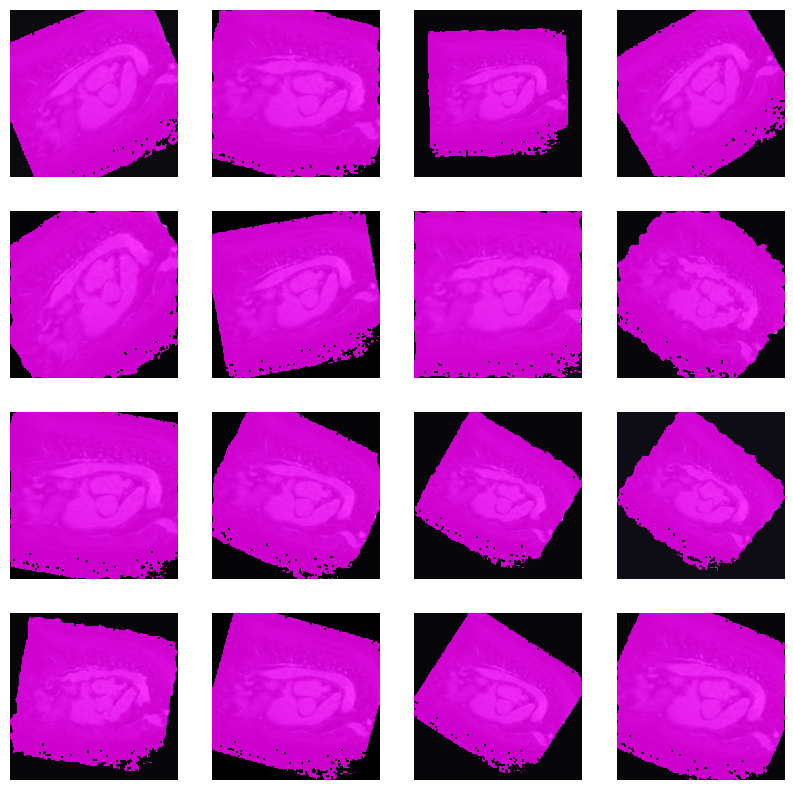

In [33]:
# 对同一张图做数据增强，查看效果
fig = plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    
    # 获取数据
    img,mask = dataset[100]
    
    
    # 将mask和图片绘制在一起
    img_display = img[0]
    mask_display = mask[0]
    # 将mask_display像素值为0处遮挡起来
    mask = np.ma.masked_where(mask_display==0,mask_display)
    plt.imshow(img_display,cmap='bone')
    plt.imshow(mask,alpha=0.8,cmap='spring')
    
    plt.axis('off')
    
plt.show()

In [34]:
# 使用dataloader加载数据
batch_size = 16
num_workers = 0

train_dataset = SegmentDataset('train',seq)
test_dataset = SegmentDataset('test',None)

# dataloader
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=False)

In [35]:
len(train_loader)

121

In [36]:
# 使用loader加载显示一些图片

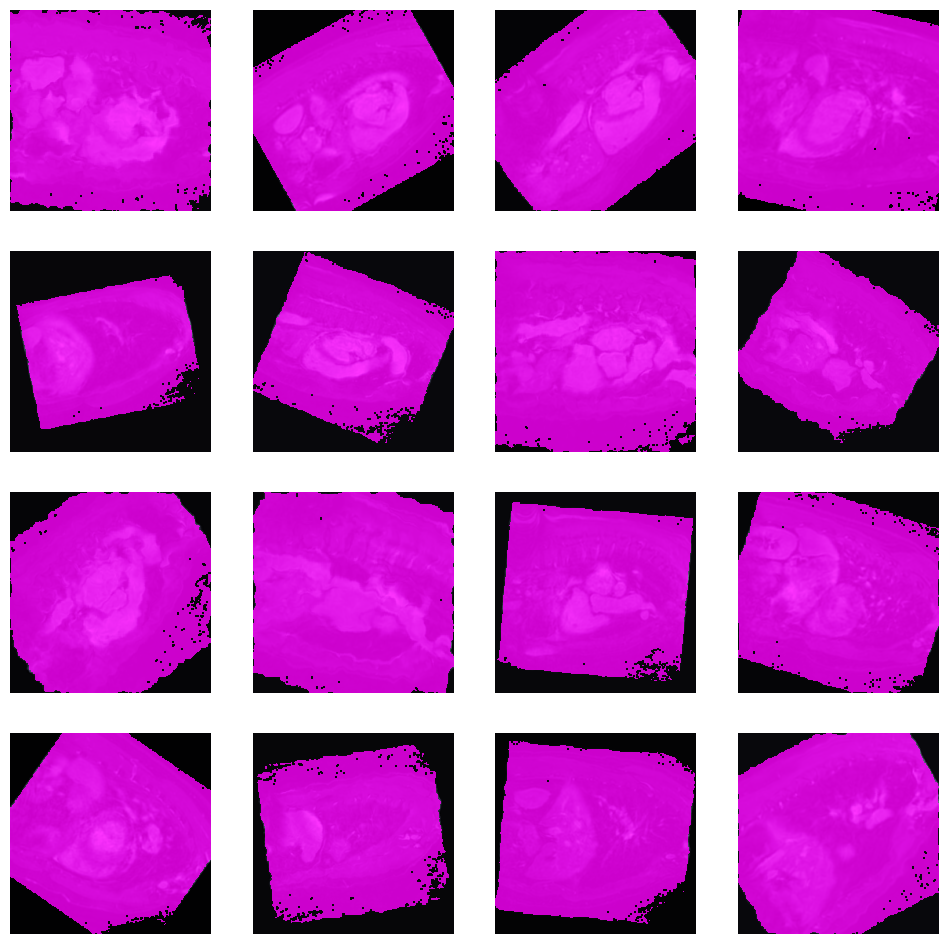

In [37]:
for x in train_loader:
   # 设置画布大小
    fig = plt.figure(figsize=(12,12))
    for i in range(16):
        plt.subplot(4,4,i+1)
        # 获取图片及标注
        img,mask = x[0][i][0],x[1][i][0]
        mask = np.ma.masked_where(mask==0,mask)
        plt.imshow(img,cmap='bone')
        plt.imshow(mask,alpha=0.8,cmap='spring')
        plt.axis('off')
    plt.show()
    break